In [13]:
# =========================
#
# Titel : HPC Game Of Life
# Author: Dimitri Dening
# Date  : 29.06.2021
#
# =========================

from IPython.display import display
import matplotlib.pyplot as plt
import contextlib
import pandas as pd
import numpy as np
import json
import csv
import os

In [4]:
%matplotlib inline

### Messdaten von Comm and Calc umformatieren

In [14]:
data_dir = '../rawdata/test_dstrb/'
data_sets = [folder.path for folder in os.scandir(data_dir) if folder.is_dir()]

for index, data_set in enumerate(data_sets):
    
    sub_data_sets = [folder.path for folder in os.scandir(data_set) if folder.is_dir()]
   
    for sub_data_set in sub_data_sets:
        # Calc Data
        files_calc = [filename for filename in os.listdir(sub_data_set) if filename.startswith('dstrb_calc')]
        
        if not files_calc:
            pass
        else: 
            for filename in files_calc:
                file_dir = sub_data_set + "\\" + filename
                # reading the data from the file
                with open(file_dir, 'r') as f:
                    current_data = f.read()
                    with open(file_dir, 'w') as over_write:
                        current_data = current_data.replace(" ", ",")
                        over_write.write(current_data)
          
        # Comm Data
        files_comm = [filename for filename in os.listdir(sub_data_set) if filename.startswith('dstrb_comm')]
        
        if not files_comm:
            pass
        else:
            for filename in files_comm:
                file_dir = sub_data_set + "\\" + filename
                # reading the data from the file
                with open(file_dir, 'r') as f:
                    current_data = f.read()
                    with open(file_dir, 'w') as over_write:
                        current_data = current_data.replace(" ", ",")
                        over_write.write(current_data)       

### Zusammenführen von Messdaten (Distributed)

,method,threads,frames,size,time
0,dstrb,2,20000,500,6.464954
1,dstrb,4,20000,500,3.684016
2,dstrb,6,20000,500,2.836859
3,dstrb,8,20000,500,2.406421
4,dstrb,10,20000,500,2.016060
...,...,...,...,...,...
59,dstrb,120,20000,500,2.291454
60,dstrb,122,20000,500,2.529919
61,dstrb,124,20000,500,3.230050
62,dstrb,126,20000,500,5.104572


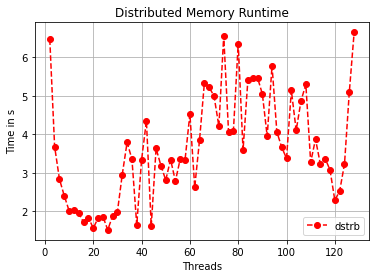

In [16]:
data_dir = '../rawdata/test_dstrb/'
data_sets = [folder.path for folder in os.scandir(data_dir) if folder.is_dir()]

for index, data_set in enumerate(data_sets):
    time_dstrb = []
    sub_data_sets = [folder.path for folder in os.scandir(data_set) if folder.is_dir()]
    
    for sub_data_set in sub_data_sets:
        files = [filename for filename in os.listdir(sub_data_set) 
                 if (filename.startswith('dstrb_2021')
                 or filename.startswith('dstrb_sr') 
                 or filename.startswith('dstrb_lh'))
                 and filename.endswith('.txt')]
        if not files:
            break
            
        file_accumulate = sub_data_set + '/accumulated_dstrb.csv'
    
        with contextlib.suppress(FileNotFoundError):
            os.remove(file_accumulate)
          
        header = ['method', 'threads', 'frames', 'size', 'time']
        
        with open(file_accumulate, 'w', encoding='UTF8', newline='\n') as f:
            writer = csv.writer(f)
            # write the header
            # writer.writerow(header)
                
            for filename in files:
                data = []         
                file_dir = sub_data_set + "\\" + filename
            
                # reading the data from the file
                with open(file_dir) as f:
                    current_data = f.read()
            
                # reconstructing the data as a dictionary
                js = json.loads(current_data)
          
                data.append(js.get("method"))
                data.append(int(js.get("threads")))
                data.append(js.get("frames")) 
                data.append(js.get("size"))
                data.append(float(js.get("time")))
            
                # write the data
                writer.writerow(data)
                
        # =====================================================
        #
        #                  Mittelwert bestimmen
        #
        # =====================================================
        file_accumulate_dstrb = [filename for filename in os.listdir(sub_data_set) if filename.startswith('accumulated_dstrb.csv')]

        if not file_accumulate_dstrb:
            break
            
        file_accumulate_dstrb_mean = sub_data_set + '/accumulated_dstrb.csv'
        df_dstrb = pd.read_csv(file_accumulate_dstrb_mean, names=('method', 'threads', 'frames', 'size', 'time'))      
        df_time_dstrb = pd.DataFrame(df_dstrb, columns=['time'])       
        time_dstrb.append(np.array(df_time_dstrb.values.tolist()))
              
    if time_dstrb and len(time_dstrb) > 1:
        t_mean = np.mean(time_dstrb, axis=0)
        t_std = np.std(time_dstrb, axis=0, ddof=1)

        filename_dstrb = data_set + '/dstrb_data.csv'
        with open(filename_dstrb, 'w', encoding='UTF8', newline='') as f:
            writer = csv.writer(f)
    
            for idx in range(len(df_dstrb)):
                data = []
                data.append(df_dstrb['method'].values[idx])
                data.append(df_dstrb['threads'].values[idx])
                data.append(df_dstrb['frames'].values[idx])
                data.append(df_dstrb['size'].values[idx])
                data.append(t_mean[idx][0])
                data.append(t_std[idx][0])
                # write the data
                writer.writerow(data)
           
        # =====================================================
        #
        #                      Plots  
        #
        # =====================================================
        
        df = pd.read_csv(file_accumulate_dstrb_mean, names=('method', 'threads', 'frames', 'size', 'time'))
        #df = pd.DataFrame(df, columns=['threads', 'time']) 
        display(df)   
        
        method = df['method'][0]
        df.plot(x='threads', y='time', style="ro--", label=method) # kind='scatter'
        plt.legend(loc="best")
        plt.title("Distributed Memory Runtime")
        plt.xlabel("Threads")
        plt.ylabel("Time in s")
        # plt.savefig('dstr-dataset-%s.png' % str(index), bbox_inches='tight')
        plt.grid()
        plt.show() 
        

### Zusammenführen von Comm und Calc Messungen (Distributed)

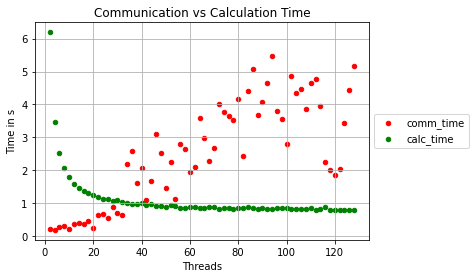

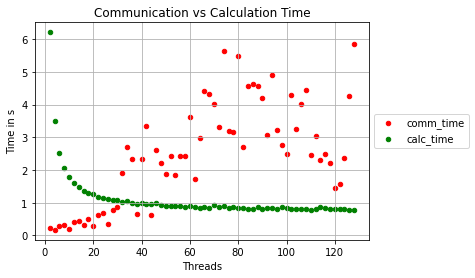

In [36]:
data_dir = '../rawdata/test_dstrb/'
data_sets = [folder.path for folder in os.scandir(data_dir) if folder.is_dir()]

for index, data_set in enumerate(data_sets):
    time_comm = []
    time_calc = []
    sub_data_sets = [folder.path for folder in os.scandir(data_set) if folder.is_dir()]
    
    for sub_data_set in sub_data_sets:
        
        # =====================================================
        #
        #          Messdaten Comm Time (Distributed)
        #
        # =====================================================
        files = [filename for filename in os.listdir(sub_data_set) if filename.startswith('dstrb_comm')]
        
        if not files:
            pass
        else:
            
            file_accumulate_comm = sub_data_set + '/accumulated_dstrb_comm.csv'
    
            with contextlib.suppress(FileNotFoundError):
                os.remove(file_accumulate_comm)
          
            header = ['time', 'threads']
        
            with open(file_accumulate_comm, 'w', encoding='UTF8', newline='\n') as f:
                writer = csv.writer(f, delimiter=' ', escapechar=' ', quoting=csv.QUOTE_NONE)
                # write the header
                # writer.writerow(header)
                
                for filename in files:
                    data = []         
                    file_dir = sub_data_set + "\\" + filename
            
                    # reading the data from the file
                    with open(file_dir) as f:
                        current_data = f.read()
            
                    data.append(current_data[:-1])
                    # write the data
                    writer.writerow(data)
                    
            # =====================================================
            #
            #                  Mittelwert bestimmen
            #
            # =====================================================
            files_comm = [filename for filename in os.listdir(sub_data_set) if filename.startswith('accumulated_dstrb_comm')]
        
            if files_comm:
                file_accumulate_comm = sub_data_set + '/accumulated_dstrb_comm.csv'            
                df_comm = pd.read_csv(file_accumulate_comm, names=('time', 'threads'))                  
                df_time_comm = pd.DataFrame(df_comm, columns=['time'])                
                time_comm.append(np.array(df_time_comm.values.tolist()))
                
        # =====================================================
        #
        #       Messdaten Calculation Time (Distributed) 
        #
        # =====================================================
        files = [filename for filename in os.listdir(sub_data_set) if filename.startswith('dstrb_calc')]
        
        if not files:
            pass
        else:   
            file_accumulate_calc = sub_data_set + '/accumulated_dstrb_calc.csv'
    
            with contextlib.suppress(FileNotFoundError):
                os.remove(file_accumulate_calc)
          
            header = ['time', 'threads']
        
            with open(file_accumulate_calc, 'w', encoding='UTF8', newline='\n') as f:
                writer = csv.writer(f, delimiter=' ', escapechar=' ', quoting=csv.QUOTE_NONE)
                # write the header
                # writer.writerow(header)
                
                for filename in files:
                    data = []         
                    file_dir = sub_data_set + "\\" + filename
            
                    # reading the data from the file
                    with open(file_dir) as f:
                        current_data = f.read()
            
                    data.append(current_data[:-1])
                    # write the data
                    writer.writerow(data)
                    
            # =====================================================
            #
            #                  Mittelwert bestimmen
            #
            # =====================================================
            files_calc = [filename for filename in os.listdir(sub_data_set) if filename.startswith('accumulated_dstrb_calc')]
            
            if files_calc: 
                file_accumulate_calc = sub_data_set + '/accumulated_dstrb_calc.csv'
                df_calc = pd.read_csv(file_accumulate_calc, names=('time', 'threads'))
                df_time_calc = pd.DataFrame(df_calc, columns=['time']) 
                time_calc.append(np.array(df_time_calc.values.tolist()))
        
        if time_comm:
            t_mean = np.mean(time_comm, axis=0)
            t_std = np.std(time_comm, axis=0, ddof=1)

            filename_comm = data_set + '/dstrb_data_comm.csv'
            with open(filename_comm, 'w', encoding='UTF8', newline='') as f:
                writer = csv.writer(f)
    
                for idx in range(len(df_comm)):
                    data = []
                    data.append(df_comm['threads'].values[idx])
                    data.append(t_mean[idx][0])
                    data.append(t_std[idx][0])
                    # write the data
                    writer.writerow(data)
                
        if time_calc:
            t_mean = np.mean(time_calc, axis=0)
            t_std = np.std(time_calc, axis=0, ddof=1)

            filename_calc = data_set + '/dstrb_data_calc.csv'
            with open(filename_calc, 'w', encoding='UTF8', newline='') as f:
                writer = csv.writer(f)
    
                for idx in range(len(df_calc)):
                    data = []
                    data.append(df_calc['threads'].values[idx])
                    data.append(t_mean[idx][0])
                    data.append(t_std[idx][0])
                    # write the data
                    writer.writerow(data)
           
        
        # =====================================================
        #
        #       Plots Comm & Calculation Time (Distributed) 
        #
        # =====================================================
        
        df_comm = pd.read_csv(file_accumulate_comm, names=('time', 'threads'))
        df_comm = pd.DataFrame(df_comm, columns=['time', 'threads']) 
        
        df_calc = pd.read_csv(file_accumulate_calc, names=('time', 'threads'))
        df_calc = pd.DataFrame(df_calc, columns=['time', 'threads']) 
        
        # ax = df_comm.plot(x='threads', y='time', style="ro--", label='comm_time');      
        # df_calc.plot(x='threads', y='time', style="go--", ax = ax, label='calc_time');
        
        ax = df_comm.plot.scatter(x="threads", y="time", color="Red", label="comm_time")
        df_calc.plot.scatter(x="threads", y="time", color="Green", label="calc_time", ax=ax);

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title("Communication vs Calculation Time")
        plt.xlabel("Threads")
        plt.ylabel("Time in s")
        plt.grid()
        plt.show()  
        

### Distributed mit Kommunikations- und Berechnungszeit

,method,threads,frames,size,t_mean,t_std
0,dstrb,2,20000,500,6.451807,0.018593
1,dstrb,4,20000,500,3.686496,0.003507
2,dstrb,6,20000,500,2.835460,0.001978
3,dstrb,8,20000,500,2.403449,0.004204
4,dstrb,10,20000,500,2.025422,0.013241
...,...,...,...,...,...,...
59,dstrb,120,20000,500,2.494022,0.286475
60,dstrb,122,20000,500,2.703448,0.245407
61,dstrb,124,20000,500,3.753411,0.740145
62,dstrb,126,20000,500,5.181195,0.108361


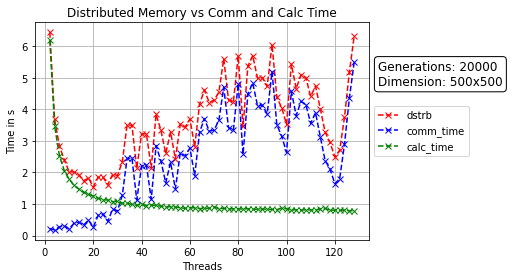

In [50]:
data_dir = '../rawdata/test_dstrb/'
data_sets = [folder.path for folder in os.scandir(data_dir) if folder.is_dir()]

for index, data_set in enumerate(data_sets): 
    
    state = True
    
    file_data = data_set + '/dstrb_data.csv'
    file_comm = data_set + '/dstrb_data_comm.csv'
    file_calc = data_set + '/dstrb_data_calc.csv'
    
    df_data = pd.read_csv(file_data, names=('method', 'threads', 'frames', 'size', 't_mean', 't_std'))
    df_comm = pd.read_csv(file_comm, names=('threads', 't_mean', 't_std'))
    
    try:
        df_calc = pd.read_csv(file_calc, names=('threads', 't_mean', 't_std'))
    except:
        state = False

    # display(df_data)   
    
    method = df_data['method'][0]
    ax = df_data.plot(x='threads', y='t_mean', style="rx--", label=method)
    fx = df_comm.plot(x='threads', y='t_mean', style="bx--", ax=ax, label='comm_time')
    # plt.errorbar(df_comm['threads'], df_comm['t_mean'], yerr=df_comm['t_std'], fmt=' ', color='red', ecolor='black', elinewidth=1, capsize=5, label="std deviation comm")
    
    if state:
        df_calc.plot(x='threads', y='t_mean', style="gx--", ax=fx, label='calc_time')
        # plt.errorbar(df_calc['threads'], df_calc['t_mean'], yerr=df_calc['t_std'], fmt=' ', color='red', ecolor='grey', elinewidth=1, capsize=5, label="std deviation calc")
      
    
    textstr = '\n'.join((
        r'Generations: %i' % df_data['frames'].values[0],
        r'Dimension: %ix%i' % (df_data['size'].values[0], df_data['size'].values[0])))
    
    plt.figtext(0.92, 0.7, textstr, fontsize=12, ha="left", va="center",
                bbox=dict(boxstyle="round", edgecolor='black', facecolor='none',))
    
    display(df_data)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Distributed Memory vs Comm and Calc Time")
    plt.xlabel("Threads")
    plt.ylabel("Time in s")
    plt.grid()
    plt.savefig('dstrb-vs-comm-calc-500.png', bbox_inches='tight')
    plt.show() 

### Auswertung Distributed (Gesamt)

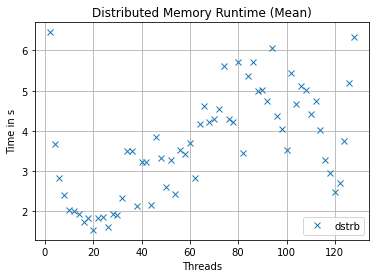

In [20]:
data_dir = '../rawdata/test_dstrb/'
data_sets = [folder.path for folder in os.scandir(data_dir) if folder.is_dir()]

my_plots = []
my_sub_plots = []
for index, data_set in enumerate(data_sets):
    
    filename = data_set + '/dstrb_data.csv'
    with open(filename, 'r', encoding='UTF8', newline='') as f:            
         
        df_mean = pd.read_csv(filename, names=('method', 'threads', 'frames', 'size', 't_mean', 't_std'))
        df_sub = pd.DataFrame(df_mean, columns=['threads', 't_mean', 't_std']) 
        # display(df_sub)
        my_plots.append(df_mean)
        my_sub_plots.append(df_sub)
        
for frame in my_plots:
    plt.plot(frame['threads'], frame['t_mean'], "x", label=frame['method'][0])
    # plt.errorbar(df_mean['threads'], df_mean['t_mean'], yerr=df_mean['t_std'], fmt=' ', color='red', ecolor='grey', elinewidth=1, capsize=5)
          
# df_mean.plot(x='threads', y='t_mean', style="ro--", label=method) # kind='scatter' , yerr='t_std', capsize=4, rot=0       
# plt.errorbar(df_mean['threads'], df_mean['t_mean'], yerr=df_mean['t_std'], fmt=' ', color='red', ecolor='grey', elinewidth=1, capsize=5, label="std deviation")

plt.legend(loc="best")
plt.title("Distributed Memory Runtime (Mean)")
plt.xlabel("Threads")
plt.ylabel("Time in s")
plt.grid()
plt.savefig('dstrb-runtime.png', bbox_inches='tight')
plt.show()

### Speedup

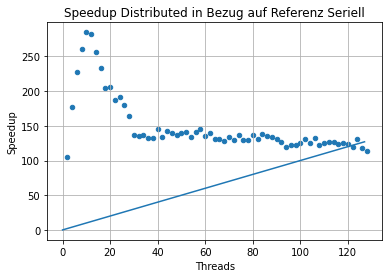

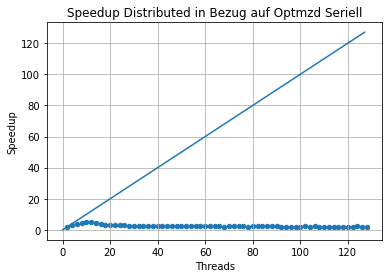

In [25]:
data_dir = '../rawdata/test_srl/'
data_sets = [folder.path for folder in os.scandir(data_dir) if folder.is_dir()]

p_exists = False
s_exists = False

for index, data_set in enumerate(data_sets):
    
    try:
        file_dir_dstrb = data_set + '/dstrb_data.csv'     
        data_dstrb = pd.read_csv(file_dir_dstrb, names=('method', 'threads', 'frames', 'ssize', 't_mean', 't_std'))
        p_exists = True
        #display(data_dstrb)
    except:
        pass
        
    try:
        file_dir_ser = data_set + '/seriell_data.csv'
        file_dir_opt = data_set + '/optmzd_data.csv'
        
        data_seriell = pd.read_csv(file_dir_ser, names=('method', 'threads', 'frames', 'ssize', 't_mean', 't_std'))
        data_optmzd = pd.read_csv(file_dir_opt, names=('method', 'threads', 'frames', 'ssize', 't_mean', 't_std'))
        s_exists = True 
        
        # display(data_seriell)
        # display(data_optmzd)
     
    except:
        pass
    
if p_exists and s_exists:
    seriell = pd.DataFrame(data_seriell, columns=['ssize', 't_mean']) 
    optmzd = pd.DataFrame(data_optmzd, columns=['ssize', 't_mean']) 
    my_dstrb = pd.DataFrame(data_dstrb, columns=['threads', 'size', 't_mean']) 

    my_dstrb['t_mean'] = seriell[seriell.ssize == 1000]['t_mean'].values[0]/my_dstrb['t_mean']
    my_dstrb.plot(x='threads', y='t_mean', kind='scatter', grid=True)
    plt.plot(np.arange(128), np.arange(128))
    plt.title("Speedup Distributed in Bezug auf Referenz Seriell")
    plt.xlabel("Threads")
    plt.ylabel("Speedup")

    my_dstrb = pd.DataFrame(data_dstrb, columns=['threads', 'size', 't_mean']) 
    my_dstrb['t_mean'] = optmzd[optmzd.ssize == 1000]['t_mean'].values[0]/my_dstrb['t_mean']
    my_dstrb.plot(x='threads', y='t_mean', kind='scatter', grid=True)
    plt.plot(np.arange(128), np.arange(128))
    # plt.legend(loc="best")
    plt.title("Speedup Distributed in Bezug auf Optmzd Seriell")
    plt.xlabel("Threads")
    plt.ylabel("Speedup")